In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [3]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import os
import librosa
import librosa.display
import soundfile as sf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam

# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to [-1, 1] range and expand dimensions for CNN
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)

# Define buffer size and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 128

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define Generator Model
def build_generator():
    model = Sequential([
        Input(shape=(100,)),
        Dense(7*7*256, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define Discriminator Model
def build_discriminator():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, (5,5), strides=(2,2), padding='same'),
        LeakyReLU(),

        Conv2D(128, (5,5), strides=(2,2), padding='same'),
        BatchNormalization(),
        LeakyReLU(),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Training setup
EPOCHS = 100  # Increased to 100 epochs
NOISE_DIM = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# Load saved weights if available
if os.path.exists("generator.weights.h5"):
    generator.load_weights("generator.weights.h5")
    print("✅ Loaded generator weights successfully.")
else:
    print("⚠️ No saved generator weights found. Training required.")

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.axis('off')

    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()
    plt.close(fig)

# Store loss values for plotting
gen_losses = []
disc_losses = []

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training function with loss tracking
def train(dataset, epochs):
    for epoch in range(epochs):
        total_gen_loss = 0
        total_disc_loss = 0
        batch_count = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            batch_count += 1

        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count

        gen_losses.append(avg_gen_loss.numpy())
        disc_losses.append(avg_disc_loss.numpy())

        print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {avg_gen_loss:.4f} - Discriminator Loss: {avg_disc_loss:.4f}")

        if (epoch + 1) % 10 == 0:  # Display image every 10 epochs
            print(f"📸 Generating images at epoch {epoch + 1}...")
            generate_and_save_images(generator, epoch + 1, seed)

    generator.save_weights("generator.weights.h5")
    print("✅ Training completed!")
    plot_losses()# Function to plot generator and discriminator loss
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss", color="blue")
    plt.plot(disc_losses, label="Discriminator Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_loss_plot.png")
    plt.show()



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step
⚠️ No saved generator weights found. Training required.


Epoch 1/100 - Generator Loss: 1.5629 - Discriminator Loss: 0.6137
Epoch 2/100 - Generator Loss: 1.5378 - Discriminator Loss: 0.7138
Epoch 3/100 - Generator Loss: 1.5509 - Discriminator Loss: 0.6937
Epoch 4/100 - Generator Loss: 1.6038 - Discriminator Loss: 0.7469
Epoch 5/100 - Generator Loss: 1.6374 - Discriminator Loss: 0.7595
Epoch 6/100 - Generator Loss: 1.6220 - Discriminator Loss: 0.7203
Epoch 7/100 - Generator Loss: 1.8811 - Discriminator Loss: 0.6313
Epoch 8/100 - Generator Loss: 2.0264 - Discriminator Loss: 0.5273
Epoch 9/100 - Generator Loss: 1.9783 - Discriminator Loss: 0.5042
Epoch 10/100 - Generator Loss: 2.1684 - Discriminator Loss: 0.4176
📸 Generating images at epoch 10...


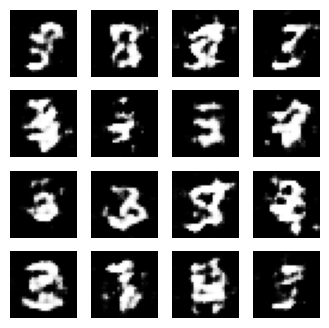

Epoch 11/100 - Generator Loss: 2.5215 - Discriminator Loss: 0.2859
Epoch 12/100 - Generator Loss: 2.2120 - Discriminator Loss: 0.3775
Epoch 13/100 - Generator Loss: 2.5407 - Discriminator Loss: 0.2967
Epoch 14/100 - Generator Loss: 2.2729 - Discriminator Loss: 0.4220
Epoch 15/100 - Generator Loss: 2.1720 - Discriminator Loss: 0.4574
Epoch 16/100 - Generator Loss: 1.9517 - Discriminator Loss: 0.5089
Epoch 17/100 - Generator Loss: 1.9213 - Discriminator Loss: 0.5429
Epoch 18/100 - Generator Loss: 1.8200 - Discriminator Loss: 0.5550
Epoch 19/100 - Generator Loss: 1.8010 - Discriminator Loss: 0.5432
Epoch 20/100 - Generator Loss: 1.7899 - Discriminator Loss: 0.5574
📸 Generating images at epoch 20...


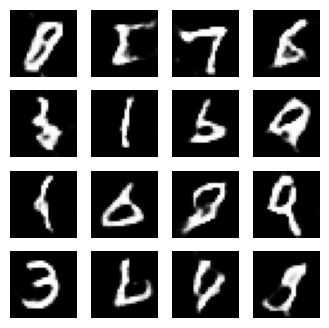

Epoch 21/100 - Generator Loss: 1.8265 - Discriminator Loss: 0.5437
Epoch 22/100 - Generator Loss: 1.8601 - Discriminator Loss: 0.5300
Epoch 23/100 - Generator Loss: 1.8511 - Discriminator Loss: 0.5360
Epoch 24/100 - Generator Loss: 1.8775 - Discriminator Loss: 0.5375
Epoch 25/100 - Generator Loss: 1.8791 - Discriminator Loss: 0.5410
Epoch 26/100 - Generator Loss: 1.8739 - Discriminator Loss: 0.5357
Epoch 27/100 - Generator Loss: 1.9139 - Discriminator Loss: 0.5251
Epoch 28/100 - Generator Loss: 1.9467 - Discriminator Loss: 0.5272
Epoch 29/100 - Generator Loss: 1.9540 - Discriminator Loss: 0.5329
Epoch 30/100 - Generator Loss: 1.9570 - Discriminator Loss: 0.5242
📸 Generating images at epoch 30...


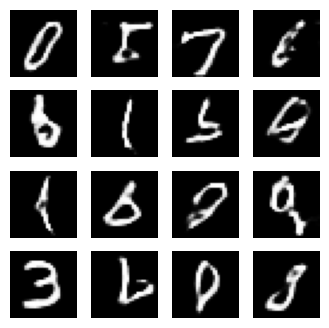

Epoch 31/100 - Generator Loss: 1.9535 - Discriminator Loss: 0.5276
Epoch 32/100 - Generator Loss: 1.9663 - Discriminator Loss: 0.5211
Epoch 33/100 - Generator Loss: 1.9902 - Discriminator Loss: 0.5205
Epoch 34/100 - Generator Loss: 1.9871 - Discriminator Loss: 0.5198
Epoch 35/100 - Generator Loss: 2.0160 - Discriminator Loss: 0.5173
Epoch 36/100 - Generator Loss: 2.0248 - Discriminator Loss: 0.5315
Epoch 37/100 - Generator Loss: 1.9896 - Discriminator Loss: 0.5216
Epoch 38/100 - Generator Loss: 2.0098 - Discriminator Loss: 0.4927
Epoch 39/100 - Generator Loss: 2.0481 - Discriminator Loss: 0.5135
Epoch 40/100 - Generator Loss: 2.0546 - Discriminator Loss: 0.5102
📸 Generating images at epoch 40...


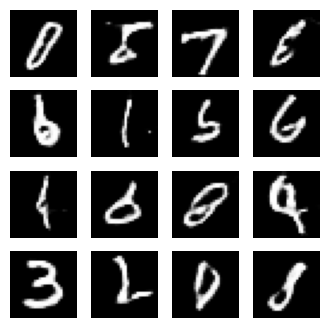

Epoch 41/100 - Generator Loss: 2.0692 - Discriminator Loss: 0.5049
Epoch 42/100 - Generator Loss: 2.0645 - Discriminator Loss: 0.5056
Epoch 43/100 - Generator Loss: 2.0808 - Discriminator Loss: 0.4937
Epoch 44/100 - Generator Loss: 2.0861 - Discriminator Loss: 0.4958
Epoch 45/100 - Generator Loss: 2.1041 - Discriminator Loss: 0.5002
Epoch 46/100 - Generator Loss: 2.1101 - Discriminator Loss: 0.5080
Epoch 47/100 - Generator Loss: 2.0823 - Discriminator Loss: 0.4980
Epoch 48/100 - Generator Loss: 2.1323 - Discriminator Loss: 0.4879
Epoch 49/100 - Generator Loss: 2.1359 - Discriminator Loss: 0.5013
Epoch 50/100 - Generator Loss: 2.1747 - Discriminator Loss: 0.4950
📸 Generating images at epoch 50...


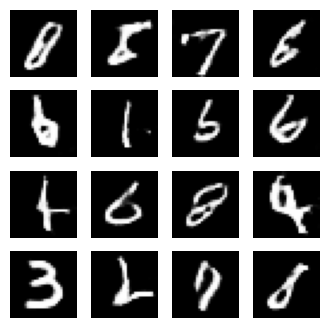

Epoch 51/100 - Generator Loss: 2.1324 - Discriminator Loss: 0.4923
Epoch 52/100 - Generator Loss: 2.1237 - Discriminator Loss: 0.4833
Epoch 53/100 - Generator Loss: 2.1579 - Discriminator Loss: 0.5068
Epoch 54/100 - Generator Loss: 2.1545 - Discriminator Loss: 0.4837
Epoch 55/100 - Generator Loss: 2.1390 - Discriminator Loss: 0.4994
Epoch 56/100 - Generator Loss: 2.1214 - Discriminator Loss: 0.4950
Epoch 57/100 - Generator Loss: 2.1323 - Discriminator Loss: 0.4952
Epoch 58/100 - Generator Loss: 2.1572 - Discriminator Loss: 0.4885
Epoch 59/100 - Generator Loss: 2.1278 - Discriminator Loss: 0.4924
Epoch 60/100 - Generator Loss: 2.1662 - Discriminator Loss: 0.4993
📸 Generating images at epoch 60...


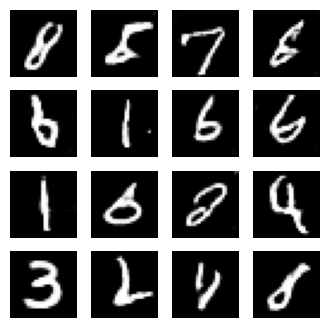

Epoch 61/100 - Generator Loss: 2.1609 - Discriminator Loss: 0.4950
Epoch 62/100 - Generator Loss: 2.1819 - Discriminator Loss: 0.4983
Epoch 63/100 - Generator Loss: 2.1837 - Discriminator Loss: 0.4938
Epoch 64/100 - Generator Loss: 2.2296 - Discriminator Loss: 0.5109
Epoch 65/100 - Generator Loss: 2.1478 - Discriminator Loss: 0.4981
Epoch 66/100 - Generator Loss: 2.1757 - Discriminator Loss: 0.4928
Epoch 67/100 - Generator Loss: 2.1273 - Discriminator Loss: 0.4906
Epoch 68/100 - Generator Loss: 2.1512 - Discriminator Loss: 0.4990
Epoch 69/100 - Generator Loss: 2.1431 - Discriminator Loss: 0.5007
Epoch 70/100 - Generator Loss: 2.1519 - Discriminator Loss: 0.4979
📸 Generating images at epoch 70...


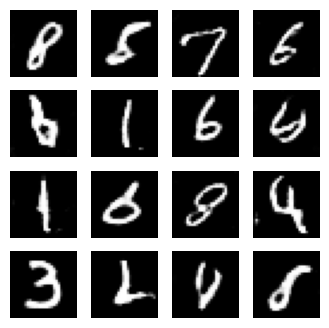

Epoch 71/100 - Generator Loss: 2.1417 - Discriminator Loss: 0.5016
Epoch 72/100 - Generator Loss: 2.1826 - Discriminator Loss: 0.5140
Epoch 73/100 - Generator Loss: 2.1558 - Discriminator Loss: 0.5097
Epoch 74/100 - Generator Loss: 2.1511 - Discriminator Loss: 0.4956
Epoch 75/100 - Generator Loss: 2.1713 - Discriminator Loss: 0.4960
Epoch 76/100 - Generator Loss: 2.1877 - Discriminator Loss: 0.5043
Epoch 77/100 - Generator Loss: 2.1741 - Discriminator Loss: 0.4921
Epoch 78/100 - Generator Loss: 2.1453 - Discriminator Loss: 0.5036
Epoch 79/100 - Generator Loss: 2.1685 - Discriminator Loss: 0.5038
Epoch 80/100 - Generator Loss: 2.1782 - Discriminator Loss: 0.4971
📸 Generating images at epoch 80...


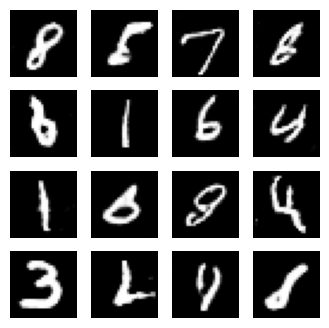

Epoch 81/100 - Generator Loss: 2.1676 - Discriminator Loss: 0.4956
Epoch 82/100 - Generator Loss: 2.1775 - Discriminator Loss: 0.5067
Epoch 83/100 - Generator Loss: 2.1468 - Discriminator Loss: 0.4934
Epoch 84/100 - Generator Loss: 2.1599 - Discriminator Loss: 0.4971
Epoch 85/100 - Generator Loss: 2.1861 - Discriminator Loss: 0.5190
Epoch 86/100 - Generator Loss: 2.1572 - Discriminator Loss: 0.5301
Epoch 87/100 - Generator Loss: 2.1613 - Discriminator Loss: 0.5038
Epoch 88/100 - Generator Loss: 2.1707 - Discriminator Loss: 0.5171
Epoch 89/100 - Generator Loss: 2.3388 - Discriminator Loss: 0.5291
Epoch 90/100 - Generator Loss: 2.2645 - Discriminator Loss: 0.4992
📸 Generating images at epoch 90...


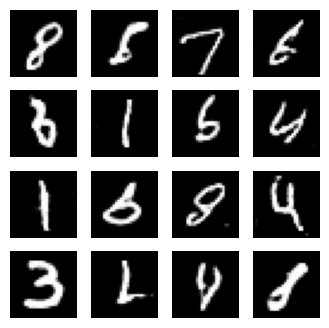

Epoch 91/100 - Generator Loss: 2.1219 - Discriminator Loss: 0.5163
Epoch 92/100 - Generator Loss: 2.1144 - Discriminator Loss: 0.5109
Epoch 93/100 - Generator Loss: 2.1287 - Discriminator Loss: 0.5298
Epoch 94/100 - Generator Loss: 2.1634 - Discriminator Loss: 0.5324
Epoch 95/100 - Generator Loss: 2.4158 - Discriminator Loss: 0.5170
Epoch 96/100 - Generator Loss: 2.3349 - Discriminator Loss: 0.5462
Epoch 97/100 - Generator Loss: 2.1966 - Discriminator Loss: 0.5576
Epoch 98/100 - Generator Loss: 2.1220 - Discriminator Loss: 0.5424
Epoch 99/100 - Generator Loss: 2.0845 - Discriminator Loss: 0.5516
Epoch 100/100 - Generator Loss: 2.0824 - Discriminator Loss: 0.5406
📸 Generating images at epoch 100...


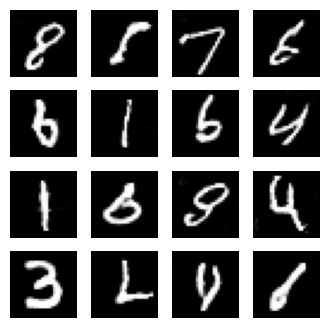

✅ Training completed!


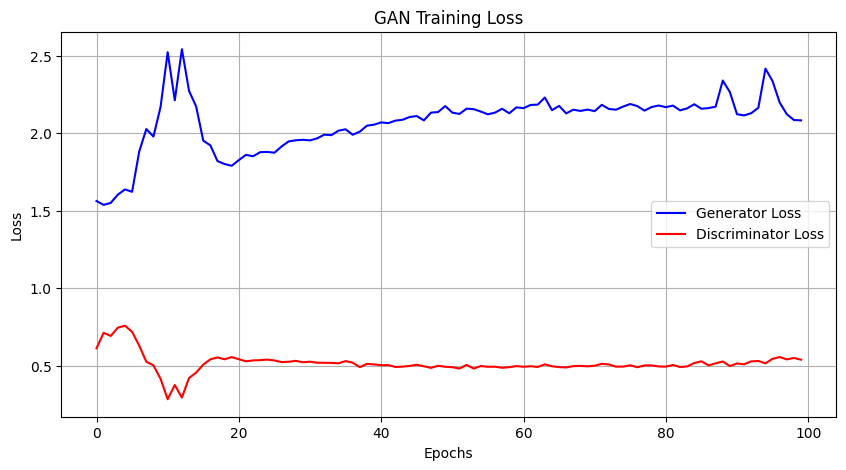

In [4]:
# Start training
train(train_dataset, EPOCHS)

In [5]:
pip install gtts

In [55]:
import gradio as gr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the trained generator model
generator = load_model("generator_model.keras")
generator.compile(optimizer=Adam(1e-4))

# Function to generate multiple digits from GAN
def generate_digits(num_samples):
    noise = tf.random.normal([num_samples, 100])  # Create 'num_samples' noise vectors
    generated_images = generator(noise, training=False).numpy()

    # Normalize generated images from [-1,1] to [0,255]
    generated_images = (generated_images.squeeze() + 1) * 127.5

    # Create a figure for displaying multiple images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    # Save the generated image grid
    plt.savefig("generated_digits.png", bbox_inches="tight")
    plt.close(fig)

    return "generated_digits.png"

# Custom CSS for Light Themed UI (Subtle Gradient)
custom_css = """
body {
    background: linear-gradient(135deg, #E3F2FD, #FFF3E0); /* Soft Light Gradient */
    font-family: 'Poppins', sans-serif;
    display: flex;
    justify-content: center;
    align-items: center;
    height: 100vh;
    margin: 0;
}
h1 {
    color: #2E7D32; /* Dark Green Title */
    font-size: 36px;
    font-weight: bold;
    text-align: center;
}
.gradio-container {
    background: rgba(255, 255, 255, 0.85); /* Soft White with Transparency */
    padding: 30px;
    border-radius: 15px;
    box-shadow: 0px 4px 20px rgba(0, 0, 0, 0.1);
    max-width: 650px;
    text-align: center;
    backdrop-filter: blur(10px);
}
.input-box {
    background: rgba(255, 204, 128, 0.8) !important; /* Light Orange Input Box */
    border-radius: 10px;
    padding: 10px;
}
.gradio-container .gr-button {
    background: #FFD700 !important; /* Gold Button */
    color: black !important;
    font-weight: bold;
    padding: 12px 20px;
    border-radius: 8px;
    transition: all 0.3s ease;
}
.gradio-container .gr-button:hover {
    background: #FFA500 !important; /* Orange Hover Effect */
}
.output-box {
    background: rgba(255, 102, 102, 0.85) !important; /* Light Red Output Box */
    padding: 15px;
    border-radius: 10px;
    box-shadow: 0px 4px 10px rgba(255, 0, 0, 0.3);
}
"""

# Gradio Interface with Centered Elements
interface = gr.Interface(
    fn=generate_digits,
    inputs=gr.Slider(1, 10, step=1, value=1, label="🖼️ Number of Digits to Generate", interactive=True, elem_classes="input-box"),
    outputs=gr.Image(label="🖌️ Generated Digits", elem_classes="output-box"),
    title="🌟 AI Handwritten Digit Generator 🎨",
    description="✨ Experience AI-generated handwritten digits in real-time! <br> Select the number of digits and let AI create unique numbers instantly. 🚀",
    theme="compact",
    css=custom_css
)

# Launch Gradio app with a Shareable Link
interface.launch(debug=True, share=True)


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1098: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-67b0f0e6-74ff81ec3c39ddcc26b4ab86;e1e549c1-e39a-4c46-a2e0-d5d1780ec368)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://310131f43b4e81f94a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7864 <> https://310131f43b4e81f94a.gradio.live
